In [ ]:
# !unzip drink_bottles.zip -d data

In [1]:
import os
import cv2
import shutil
import random

import json
import numpy as np
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchsummary import summary
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


from tqdm import tqdm
from copy import deepcopy
from sklearn.metrics import classification_report

/scratch/miniconda3/envs/fine_grained/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore")

## dataset class

#### bottle dataset

[INFO]: split: 0 | path: ./data
[INFO]: mode: train | split_file: ./data/split_0.json


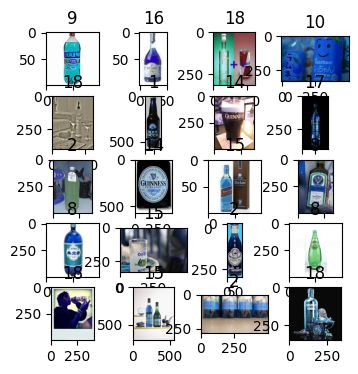


class distribution with data size of:  12325


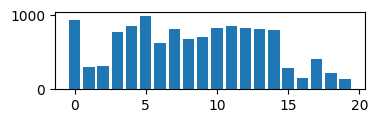

----------------------------------------------------
[INFO]: split: 1 | path: ./data
[INFO]: mode: test | split_file: ./data/split_1.json


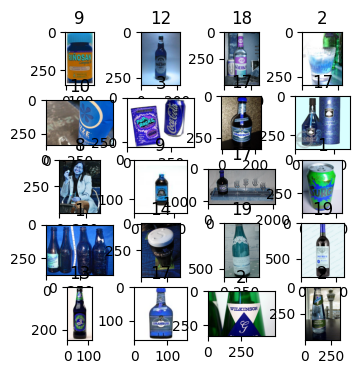


class distribution with data size of:  6162


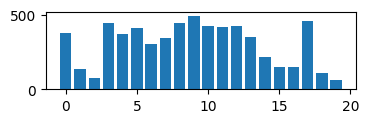

----------------------------------------------------


In [43]:
from tabnanny import verbose


class BottleDataset(Dataset):
  def __init__(self, data_path="./data", split=0, mode="train", verbose=1):
    
    self.split = split
    self.mode = mode
    self.data_path = data_path

    print(f"[INFO]: split: {split} | path: {data_path}")
    print(f"[INFO]: mode: {mode} | split_file: {self.data_path +'/split_'+ str(self.split) +'.json'}")

    with open(self.data_path +'/split_'+ str(self.split) +'.json','r') as fp:
        self.gt_annotations = json.load(fp)

    if self.mode == "train":
      self.transform = transforms.Compose([
          transforms.Resize((256, 256)),
          transforms.RandomRotation(degrees=15),
          transforms.ColorJitter(),
          transforms.RandomHorizontalFlip(),
          transforms.RandomCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
      ])
    else:
      self.transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
      ])

    self.image_list = list(self.gt_annotations[self.mode].keys())
    if verbose:
      self.visalize()

  def visalize(self, w=20, h=20, columns=4, rows=5):
    w = 20
    h = 20
    fig = plt.figure(figsize=(4, 4))
    for i in range(1, columns*rows +1):
        img = cv2.imread(os.path.join(self.data_path, self.image_list[i]))
        fig.add_subplot(rows, columns, i)
        plt.title(self.gt_annotations[self.mode][self.image_list[i]])
        plt.imshow(img)
    plt.show()
    data_dist = Counter(self.gt_annotations[self.mode].values())
    print("\nclass distribution with data size of: ", sum(data_dist.values()))
    plt.figure(figsize=(4, 1))
    plt.bar(range(len(data_dist)), list(data_dist.values()), align='center')
    plt.show()
    print("----------------------------------------------------")
    
  def __len__(self):
    return len(self.gt_annotations[self.mode])

  def __getitem__(self, idx):
    image_name = self.image_list[idx]
    img = Image.open(os.path.join(self.data_path, image_name))
    
    img_class = self.gt_annotations[self.mode][image_name]
    label = np.zeros(20)
    label[int(img_class) - 1] = 1
    label = torch.from_numpy(label)
    label = label.type(torch.FloatTensor)

    if self.transform:
      img = self.transform(img)
      
    return img, label

dataset = BottleDataset(mode="train", split=0)
dataset = BottleDataset(mode="test", split=1)

## helper functions

In [49]:
def get_dataloaders(names=['bottle'], verbose=1,
                    train_batch_size=128, val_batch_size=16,
                    config_dict={
                        "bottle":{"path":"./data/", "split":2},
                        "activity":{"path":"./data/activity"}, 
                        "context":{"path":"./data/context"}},
                    ):
                    
    output_dict = {}

    for d_type in names:

        data_path = config_dict[d_type]['path']
        
        if d_type == "bottle":
            train_dataset = BottleDataset(data_path, mode='train',
                                          split=config_dict[d_type]['split'],
                                          verbose=verbose)
                                          
            val_dataset = BottleDataset(data_path, mode='test',
                                        split=config_dict[d_type]['split'],
                                        verbose=verbose)
        elif d_type == "activity":
            pass
        else:
            pass
            
        train_dataloader = DataLoader(
                dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
        val_dataloader = DataLoader(
                dataset=val_dataset, batch_size=val_batch_size, shuffle=True)

        output_dict[d_type] = {"train":train_dataloader, "test":val_dataloader}

    return output_dict

In [39]:
def get_performance(model, dataloader, device='cuda'):
  label_list = None
  pred_list = None

  loop = tqdm(dataloader, total = len(dataloader), leave = True)
  for imgs, labels in loop:
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)

      if labels.ndim > 1:
        labels = torch.max(labels, 1)[1]

      if label_list is None:
        label_list = labels.detach().cpu().numpy()
      else:
        label_list = np.concatenate([label_list,
                                      labels.detach().cpu().numpy()])
        
      if pred_list is None:
        pred_list = outputs.detach().cpu().numpy().argmax(axis=1)
      else:
        pred_list = np.concatenate([pred_list,
                                      outputs.detach().cpu().numpy().argmax(axis=1)])
  print("\n\n")
  print(classification_report(label_list, pred_list))

## training

In [40]:
class Trainer:
    def __init__(self, model, train_dataloader, val_dataloader,
                output_dir="./outputs",
                epochs=10, start=0, perf_k=2,
                verbose=1, autoclean=True, d_type="bottle"):

        # verbose 0->no model summary, no performance
        # verbose 1->no model summary, yes performance
        # verbose 2->both

        self.device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.start = start
        self.verbose = verbose
        self.autoclean = autoclean
        self.d_type = d_type
        
        if self.verbose>1: 
          print(summary(self.model, (3,224,224)))

        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.output_dir = output_dir
        self.epochs = epochs
        self.optimizer = optim.Adam(self.model.parameters(), lr=2e-4) # optim.SGD(self.model.parameters(), lr=1e-1, momentum=0.9) #

        weights = self.get_weight_criterion()
        class_weights = torch.FloatTensor(weights).cuda()
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        
        self.callback_criteria = "val_loss"
        self.global_losses = {"train_loss":1e10, "val_loss" : 1e10}
        self.best_model = None
        self.perf_k = perf_k
        self.save_store = sorted(os.listdir(self.output_dir), key=lambda x:int(x))
        print(f"Pre-saved weights @ {self.output_dir} are {self.save_store}")

    def get_weight_criterion(self, dataset='bottles'):
      if dataset == 'context':
          weights = [1, 1, 2.2, 1, 1, 1, 1, 1, 4.5, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2.2, 1.5, 1, 1, 1, 1]
      elif dataset == 'bottles':
          weights = [1, 1, 1, 1, 2, 1.5, 1.5, 1, 1.5, 1, 1, 1.5, 1, 1, 1, 1.5, 1, 1, 1, 1]
      return weights

    def custom_callbacks(self, epoch, local_losses):
        self.save_store.append(epoch)
        save_epoch_path = os.path.join(self.output_dir, f"{epoch}")
        if not os.path.exists(save_epoch_path):
            os.makedirs(save_epoch_path)
        
        self.global_losses = deepcopy(local_losses)
        self.best_model = deepcopy(self.model)

        save_dict = {
            "epoch" : epoch,
            "train_loss" : local_losses['train_loss'],
            "val_loss": local_losses['val_loss'],
            "model": self.best_model.state_dict()
        }
        torch.save(save_dict, save_epoch_path + f"/{epoch}.pth")
        if self.autoclean:
          safe = 0
          while len(self.save_store) > 3:
            dir_to_delete = str(self.save_store.pop(0))
            if os.path.exists(os.path.join(self.output_dir, dir_to_delete)):
              shutil.rmtree(os.path.join(self.output_dir, dir_to_delete))
            # for preventing infinite deadlock 
            if safe > 10:
              break
            

    def train(self, do_agg=False):

      running_losses = {"train_loss":0, "val_loss" : 0}
      for epoch in range(self.start, self.epochs):
          local_losses = {"train_loss":0, "val_loss" : 0}
          
          # training loop
          agg_idx = 0
          agg_loss = 0.0

          loop = tqdm(self.train_dataloader, total = len(self.train_dataloader), leave = True)
          for imgs, labels in loop:
              imgs = imgs.to(self.device)
              labels = labels.to(self.device)
              outputs = self.model(imgs)
              if len(labels[0].shape) > 1:
                loss = self.criterion(outputs, torch.max(labels, 1)[1])
              else:
                loss = self.criterion(outputs, labels)

              agg_loss += loss
              agg_idx += 1
              local_losses['train_loss'] += loss.detach().cpu()
              running_losses['train_loss'] += loss.detach().cpu()
              
              if do_agg:
                if agg_idx > 4:
                    self.optimizer.zero_grad()
                    agg_loss.backward()
                    agg_idx = 0
                    agg_loss = 0.0
                    self.optimizer.step()
              else:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

              loop.set_description(f"{self.d_type}@Epoch [{epoch}/{self.epochs}]")
              loop.set_postfix({f"train loss": loss.item()})

              
          
          # validation loop
          with torch.no_grad():
            loop = tqdm(self.val_dataloader, total = len(self.val_dataloader), leave = True)
            for imgs, labels in loop:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(imgs)
                loss = self.criterion(outputs, labels)
                local_losses['val_loss'] += loss.detach().cpu()
                running_losses['val_loss'] += loss.detach().cpu()
                loop.set_description(f"Epoch [{epoch}/{self.epochs}]")
                loop.set_postfix({f"val loss": loss.item()})

          if epoch%self.perf_k==0 and self.verbose:
                # testing performance
                get_performance(self.model, self.val_dataloader)
          
          if epoch%20==0:
            print(f"Epoch [{epoch}/{self.epochs}] : losses: {running_losses}")
            running_losses = {"train_loss":0, "val_loss" : 0}
            
          if local_losses[self.callback_criteria] != self.global_losses[self.callback_criteria]:
              print(f"------ Saving at epoch: {epoch} ------")
              self.custom_callbacks(epoch=epoch, 
                                    local_losses=local_losses)
        
          print(local_losses)

## model

In [41]:
class CustomModel(nn.Module):
    
    def __init__(self, base_model=None, num_classes=20):
        super(CustomModel, self).__init__()
        self.num_classes = num_classes
        self.base_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True) #vgg19_bn
        self.base_model.fc = nn.Linear(512, self.num_classes) # res18 -> 512, res152 -> 2048

    def forward(self, x):
      logits = self.base_model(x)
      return logits

[INFO]: split: 2 | path: ./data/
[INFO]: mode: train | split_file: ./data//split_2.json


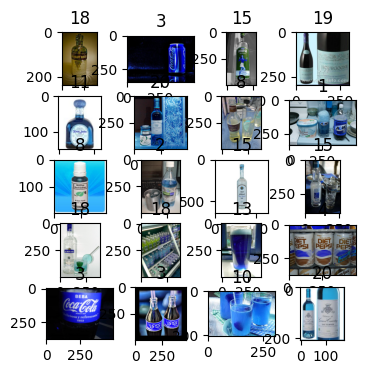


class distribution with data size of:  12325


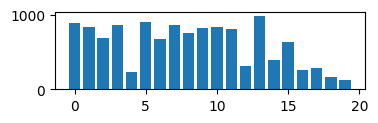

----------------------------------------------------
[INFO]: split: 2 | path: ./data/
[INFO]: mode: test | split_file: ./data//split_2.json


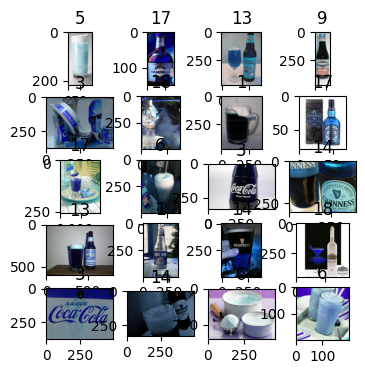


class distribution with data size of:  6163


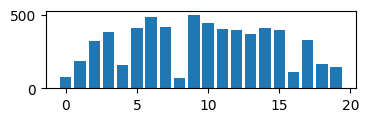

----------------------------------------------------
[INFO] Loading model for bottle from epoch: 3


Using cache found in /user/HS502/sk02100/.cache/torch/hub/pytorch_vision_v0.10.0


Pre-saved weights @ ./outputs/bottle/ are ['1', '3', '5', '6', '7', '10', '13']


100%|██████████| 193/193 [00:24<00:00,  8.01it/s]





              precision    recall  f1-score   support

           0       0.70      0.74      0.72       415
           1       0.83      0.72      0.77       441
           2       0.93      0.92      0.92       412
           3       0.94      0.94      0.94       394
           4       0.64      0.72      0.68       185
           5       0.78      0.90      0.84        72
           6       0.76      0.45      0.56       146
           7       0.82      0.59      0.69       368
           8       0.57      0.78      0.66       157
           9       0.76      0.92      0.83       401
          10       0.77      0.67      0.72       108
          11       0.66      0.61      0.63        76
          12       0.74      0.80      0.77       385
          13       0.92      0.92      0.92       498
          14       0.74      0.58      0.65       325
          15       0.81      0.66      0.73       165
          16       0.76      0.84      0.80       324
          17       0.79 

bottle@Epoch [5/50]:  29%|██▉       | 28/97 [00:18<00:46,  1.48it/s, train loss=0.578]


KeyboardInterrupt: 

In [42]:
dataloaders = get_dataloaders(['bottle'], train_batch_size=128, val_batch_size=32)
opt_dir = {"bottle":"./outputs/bottle/"}
loaded_model_weights = {"bottle":"outputs/bottle/3/3.pth"}
final_models = {}

for d_type in dataloaders:
    start = 0
    model = CustomModel()
    if loaded_model_weights[d_type] != "":
        start = int(loaded_model_weights[d_type].split("/")[-2])
        print(f"[INFO] Loading model for {d_type} from epoch: {start}")
        model.load_state_dict(torch.load(loaded_model_weights[d_type])['model'])

    train_obj = Trainer(
        model=model,
        train_dataloader=dataloaders[d_type]['train'],
        val_dataloader=dataloaders[d_type]['test'],
        output_dir=opt_dir[d_type],
        start=start+1,
        epochs=50,
        d_type=d_type
    )
    train_obj.train()
    final_models[d_type] = train_obj

## final testing

In [46]:
load_path = "outputs/bottle/4/4.pth"
load_model = CustomModel()
load_model.load_state_dict(torch.load(load_path)['model'])

Using cache found in /user/HS502/sk02100/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

In [54]:
config_dict={
            "bottle":{"path":"./data/", "split":0},
            "activity":{"path":"./data/activity"}, 
            "context":{"path":"./data/context"}
            }

In [57]:
for d_type in config_dict:
    print(f"----------{d_type}-------------")
    for split in range(0,3):
        config_dict[d_type]['split'] = split
        dataloaders = get_dataloaders(['bottle', 'activity', 'context'], train_batch_size=128, val_batch_size=32, config_dict=config_dict, verbose=0)
        get_performance(load_model.to("cuda").eval(), dataloaders[d_type]["test"])

----------bottle-------------
[INFO]: split: 0 | path: ./data/
[INFO]: mode: train | split_file: ./data//split_0.json
[INFO]: split: 0 | path: ./data/
[INFO]: mode: test | split_file: ./data//split_0.json


100%|██████████| 193/193 [00:22<00:00,  8.42it/s]





              precision    recall  f1-score   support

           0       0.69      0.71      0.70       419
           1       0.73      0.65      0.69       390
           2       0.92      0.93      0.93       422
           3       0.94      0.94      0.94       411
           4       0.61      0.70      0.65       176
           5       0.66      0.93      0.77        57
           6       0.77      0.44      0.56       138
           7       0.79      0.57      0.66       338
           8       0.48      0.73      0.58       125
           9       0.82      0.87      0.85       427
          10       0.77      0.67      0.72       123
          11       0.72      0.49      0.58        86
          12       0.68      0.79      0.73       396
          13       0.95      0.91      0.93       490
          14       0.71      0.53      0.61       337
          15       0.73      0.60      0.66       166
          16       0.78      0.85      0.81       331
          17       0.75 

100%|██████████| 193/193 [00:23<00:00,  8.19it/s]





              precision    recall  f1-score   support

           0       0.84      0.84      0.84       443
           1       0.85      0.80      0.82       369
           2       0.94      0.98      0.96       412
           3       0.98      0.97      0.97       423
           4       0.80      0.86      0.83       218
           5       0.86      0.97      0.91        63
           6       0.90      0.71      0.79       147
           7       0.95      0.73      0.83       341
           8       0.67      0.86      0.76       138
           9       0.88      0.95      0.91       378
          10       0.87      0.79      0.83       111
          11       0.89      0.71      0.79        79
          12       0.85      0.91      0.88       418
          13       0.98      0.96      0.97       492
          14       0.85      0.69      0.76       352
          15       0.86      0.87      0.87       151
          16       0.86      0.88      0.87       303
          17       0.84 

100%|██████████| 193/193 [00:23<00:00,  8.07it/s]





              precision    recall  f1-score   support

           0       0.76      0.76      0.76       415
           1       0.86      0.75      0.80       441
           2       0.95      0.96      0.95       412
           3       0.96      0.97      0.97       394
           4       0.66      0.80      0.73       185
           5       0.84      0.92      0.87        72
           6       0.74      0.49      0.59       146
           7       0.86      0.63      0.73       368
           8       0.57      0.79      0.66       157
           9       0.82      0.91      0.86       401
          10       0.79      0.65      0.71       108
          11       0.71      0.62      0.66        76
          12       0.77      0.84      0.80       385
          13       0.95      0.93      0.94       498
          14       0.77      0.58      0.66       325
          15       0.83      0.70      0.76       165
          16       0.76      0.84      0.80       324
          17       0.79 

 44%|████▍     | 85/193 [00:10<00:13,  8.30it/s]


KeyboardInterrupt: 